<a href="https://colab.research.google.com/github/raplima/2020_cores_auto/blob/master/pyscripts/experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install and download


In [ ]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version

# install detectron2:
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install -e detectron2_repo


###############################
# download, decompress the data
!gdown https://drive.google.com/uc?id=1LJfHTdmPC_o-b_5dI2uVdhU5_FKGpBTJ
!unzip cores.zip > /dev/null

# download class json from github
!wget https://raw.githubusercontent.com/raplima/2020_cores_auto/master/data/classes.json
!mv classes.json cores

In [1]:
# import necessary libraries:
import os
import json

from sklearn.model_selection import KFold

import numpy as np
from detectron2.structures import BoxMode
import cv2
import random

from matplotlib import pyplot as plt

from detectron2.data import MetadataCatalog, DatasetCatalog


In [2]:
def get_data_dicts(img_dir, files_dict, all_ks, idxs):
    """
    function to format the data into detectron2 input parameters

    Parameters
    ----------
    img_dir : string
        path to folder with images and a "classes.json" dictionary.
    files_dict : dict
        a dictionary containing image info.
    all_ks : list
        all keys from the dictionary files_dict.
    idxs : array
        the selected indexes for this split.

    Returns
    -------
    dataset_dicts : dict
        the dictionary used as input to detectron2 model

    """
    # get the classes:
    json_file = os.path.join(img_dir, "classes.json")
    with open(json_file) as f:
        ann_classes = json.load(f)
    # transform the dictionary into a list 
    classes=sorted([it for _, it in ann_classes.items()])

    dataset_dicts = []
    for idx in idxs:
        v = files_dict[all_ks[idx]]
        record = {}
        
        filename = os.path.join(img_dir, v["filename"])
        height, width = cv2.imread(filename).shape[:2]
        
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
      
        annos = v["regions"]
        objs = []
        for anno in annos:
            #assert not anno["region_attributes"]
            region = anno['region_attributes']
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": classes.index(ann_classes[region['lithofacies']]),
                "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [3]:
data_dir = 'cores'

# read main json file
json_file = os.path.join(data_dir, "vanhorn_hawkins_payne_musselman_final_json.json")
with open(json_file) as f:
    main_json = json.load(f)

# save the dictionary keys:
k = list(main_json.keys())
# create kfold
kf = KFold(n_splits=5, random_state=0, shuffle=True)

In [4]:
dataset_tag = 'cores'

# read the classes dictionary
json_file = os.path.join(data_dir, "classes.json")
with open(json_file) as f:
    classes = json.load(f)

# save a list with same format as function and metadata:
thing_classes = sorted([it for _, it in classes.items()])

# loop over splits
for fold_idx, [train_index, test_index] in enumerate(kf.split(k)):
    print(f'setting fold {fold_idx}')
    for d, indexes in zip(["train", "val"], [train_index, test_index]):
        tag = f'{dataset_tag}_{d}_{fold_idx}'
        DatasetCatalog.register(tag, lambda d=d: get_data_dicts(data_dir, main_json, k, indexes))
        MetadataCatalog.get(tag).set(thing_classes=sorted([it for _, it in classes.items()]))

print('ok')

setting fold 0
setting fold 1
setting fold 2
setting fold 3
setting fold 4
ok


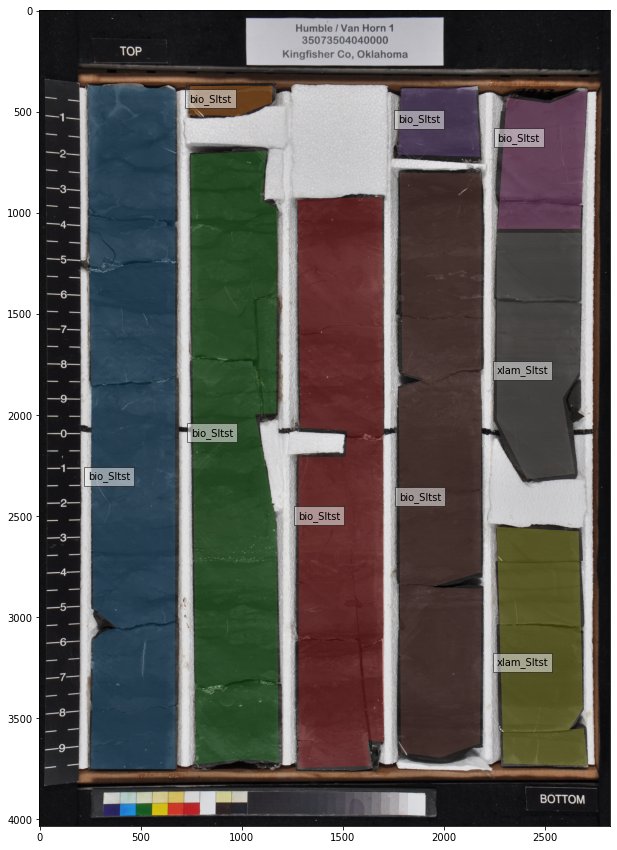

In [9]:
dataset_dicts = get_data_dicts(data_dir, main_json, k, [1,2,3,4,5,6,7,8,9])

d = random.sample(dataset_dicts, 1)[0]

img = np.rot90(plt.imread(d["file_name"]), -1)

fig, ax = plt.subplots(1, figsize=(12,15))
ax.imshow(img)

for annot in d['annotations']:
    # select the x and y segmentation points
    segx = annot['segmentation'][0][0::2]
    segy = annot['segmentation'][0][1::2]
    ax.fill(segx, segy, alpha=0.3)
    ax.text(np.min(segx), np.mean(segy), 
        s=thing_classes[annot['category_id']], 
        bbox=dict(facecolor='white', alpha=0.5))